### Phase 5 Epideimic Example


### Our Target
In this project, we try to answer the question:
In SIR model, given N (number of pupulation) and y_obs(number of infected people), what is the possible ditribution of the infection rate $\theta$?

We assume the prior of our infection rate to be Exponential with rate 1, and that since we do not know what is the realistic y_obs, we simulate it with our model `sir_sim`.

By obtaining our prior and y, we aim to approximate the posterior distribution $p(\theta|y,N)$ where:
- $\theta$: infection rate parameter
- $y$: observed number of infections
- $N$: Household size

### Model
We model this posterior based on data generated by a stochastic SIR household simulator. We compare two neural inference methods:
- Mixture Density Network (MDN)
- Conditional Normalising Flow (CNF)

Mixture Density Network(MDN), as we used before, is a combination of Gaussian distribution and Conditional Normalisin flow, is a flow that using sigmoid and affine transformation.



## Step 1 : Simulate the data
We simulate infection spread in a household using a simplified stochastic SIR process.
For each household size N , we sample : 
- $\theta \sim Exponential (1)$
- Run `sir_sim(N,theta)` to obtain a corresponding y.

Hence, We obtain tuples ($\theta$,y,N) for training and evaluation.
Where $\theta$ is our output, y and N being our input.

By choosing our N with {100,150,200,250,300} with M (number of samples per N) = 100,000, we finally obtain the data with 500,000 rows and 3 columns.

We save the data using the code `np.savetxt("theta_y_N_samples.txt", samples)`

We are lucky because now we choose the rate of our prior to be 1, in which case the $\theta$ generated has limited maximum.

In [16]:
# === 📦 Import Libraries ===
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
from scipy.stats import norm
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import os

# === 🦠 SIR Simulator ===
def sir_sim(N, lam, k=0):
    S = N - 1
    y = 1
    while y > 0:
        y -= 1
        I = 1.0 if k == 0 else np.random.gamma(shape=k, scale=1/k)
        Z = np.random.poisson(lam * I)
        for _ in range(Z):
            if np.random.rand() < S / N:
                S -= 1
                y += 1
    return N - S - 1

# === 📊 Generate Samples ===
def generate_theta_y_N_samples(M_per_N=100000, N_list=[100, 200, 300], prior_rate=1):
    all_samples = []
    for N in N_list:
        for _ in tqdm(range(M_per_N), desc=f"Generating samples for N={N}"):
            theta = np.random.exponential(scale=1 / prior_rate)
            y = sir_sim(N, lam=theta, k=0)
            all_samples.append([theta, y, N])
    return np.array(all_samples)

# === ✅ Generate + Save ===
N_list = [100,150, 200,250, 300]
samples = generate_theta_y_N_samples(M_per_N=100000, N_list=N_list)
np.savetxt("theta_y_N_samples.txt", samples)

# === 📥 Load + Normalize ===
data = np.loadtxt("theta_y_N_samples.txt")
theta_all, y_all, N_all = data[:, 0], data[:, 1].astype(int), data[:, 2].astype(int)

y_max, N_max = int(y_all.max()), int(N_all.max())
x_max = 5.0

pair_dict = defaultdict(list)
for theta_val, y_val, N_val in zip(theta_all, y_all, N_all):
    pair_dict[(y_val, N_val)].append(theta_val)

def normalize_y_N(y, N, y_max, N_max):
    return y / y_max, N / N_max


Generating samples for N=300: 100%|██████████| 100000/100000 [00:05<00:00, 19552.40it/s]


We can see from the output that for each N = 100, N = 200, N =300 ,we genetate 100000 rows for each. It is also worth noting that more time is needed to generate for big N , because for large $\theta$, it would take longer time to infect all the population.

### Visualisation on Different N
Acutally, we can plot how our y_obs varies for different $\theta $ under differen N.
We wonder if our two models could suffciently capture the distribution under different N, so a plot of all the data points is necessary.

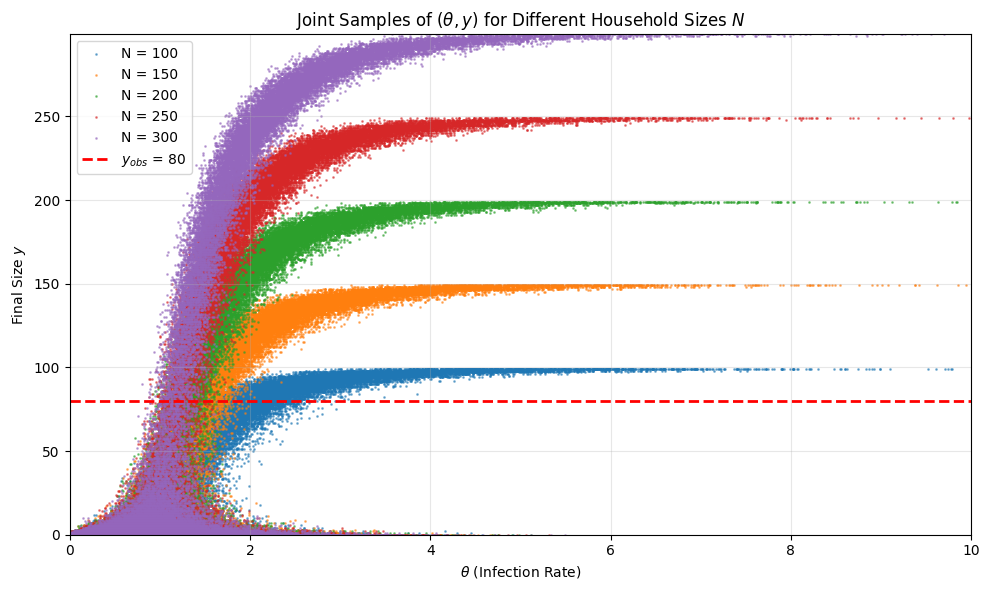

In [17]:
import matplotlib.pyplot as plt

# Choose which N values to plot
N_values_to_plot = [100,150, 200,250, 300]  # You can modify this list

plt.figure(figsize=(10, 6))

for N_target in N_values_to_plot:
    # Mask data for current N
    mask = N_all == N_target
    theta_subset = theta_all[mask]
    y_subset = y_all[mask]

    plt.scatter(theta_subset, y_subset, s=1, alpha=0.5, label=f"N = {N_target}")

# Optional: draw a horizontal line at a specific y_obs
y_obs = 80
plt.axhline(y=y_obs, color='red', linestyle='--', linewidth=2, label=r"$y_{obs}$ = 80")

# Plot settings
plt.xlabel(r"$\theta$ (Infection Rate)")
plt.ylabel("Final Size $y$")
plt.title("Joint Samples of $(\\theta, y)$ for Different Household Sizes $N$")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 10)
plt.ylim(0, max(y_all))
plt.tight_layout()
plt.show()


### See the normalized y/N 


To make the outbreak sizes comparable across different household sizes N, we normalized the final size y by dividing it by N. 

This normalization allows us to interpret the outcome as a proportion of the total population that was infected.

However, visualizing ($\theta$, y/N)  jointly for multiple N values on the same scatter plot can lead to heavy overlap, which is hard for our NN to capture the features.

In contrast, the unnormalized plot (using \( y \)) separates different \( N \) values vertically, making the scatter less dense but also less comparable in terms of proportion. For better visual clarity, alternative methods such as contour plots, hexbin plots, or separate subplots for each \( N \) may be used.


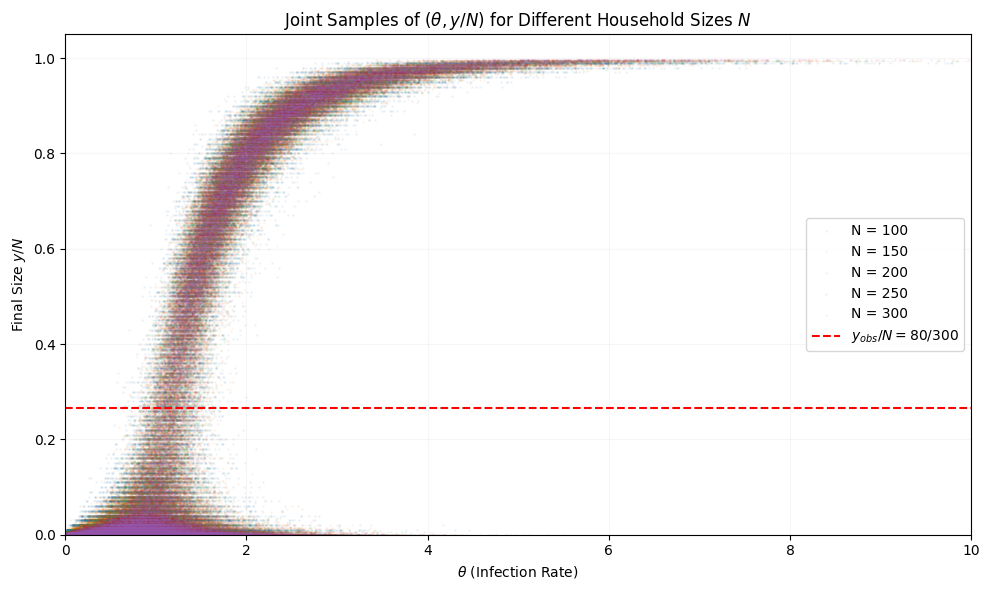

In [22]:
import matplotlib.pyplot as plt

# Choose which N values to include
N_values_to_plot = [100,150, 200,250, 300]  # or list(set(N_all)) for all unique N

plt.figure(figsize=(10, 6))

for N_target in N_values_to_plot:
    mask = N_all == N_target
    theta_subset = theta_all[mask]
    y_subset = y_all[mask]
    
    y_normalized = y_subset / N_target  # Normalize y by N
    
    plt.scatter(theta_subset, y_normalized, s=1, alpha=0.05, label=f"N = {N_target}")

# Optional: draw horizontal line for a reference normalized y_obs
y_obs = 80
plt.axhline(y=y_obs / max(N_values_to_plot), color='red', linestyle='--', label=rf"$y_{{obs}}/N = {y_obs}/{max(N_values_to_plot)}$")

# Labels and title
plt.xlabel(r"$\theta$ (Infection Rate)")
plt.ylabel(r"Final Size $y/N$")
plt.title("Joint Samples of $(\\theta, y/N)$ for Different Household Sizes $N$")
plt.legend()
plt.grid(True, alpha=0.1)
plt.xlim(0, 10)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


The red dashed line represents a reference observation $ y_{obs}/N = 80/300 \approx 0.267 $.

While admitting that some subtle differences between different N exist and may be captured by our NN, almost all points collapse into a similar region after normalization.

In this case, the idea that using y/N as our input is not a great idea.

### Model 1: Normalising Flow
We implement a 1D conditional affine flow:

- **Inputs:** $x = \theta \in (0, 1)$ (after sigmoid transformation)  
- **Condition:** normalized $(y, N)$  
- **Composed of:** affine + sigmoid transformation layers  
- **Base distribution:** standard Normal

**Loss:**

$$
\mathcal{L}_\mathrm{Flow} = -\log p_\mathrm{base}(z) - \log \left| \frac{dz}{dx} \right|
$$
#### Hyperparameters:
- Epochs: 300 
- Optimizer: Adam (lr = 1e-3)
- Loss: -log(p($\theta|y,N$)) via change of variables
- Hidden Layes: 3 layers with 64 units each
- Number of flow: 1

In [ ]:
base_dist = Normal(loc=0.0, scale=1.0)

class ConditionalAffineFlow(nn.Module):
    def __init__(self, cond_dim, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(cond_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 2)  # scale and shift
        )

    def forward(self, z, cond):
        cond_out = self.net(cond)
        scale = cond_out[:, 0:1]
        shift = cond_out[:, 1:2]
        u = torch.exp(scale) * z + shift
        x = torch.sigmoid(u)
        log_det = scale + torch.log(x * (1 - x) + 1e-6)
        return x, log_det

    def inverse(self, x, cond):
        cond_out = self.net(cond)
        scale = cond_out[:, 0:1]
        shift = cond_out[:, 1:2]
        u = torch.log(x) - torch.log1p(-x)
        z = (u - shift) / torch.exp(scale)
        log_det = -scale - torch.log(x * (1 - x) + 1e-6)
        return z, log_det

class ConditionalNormalizingFlow1D(nn.Module):
    def __init__(self, cond_dim, num_layers=1):
        super().__init__()
        self.layers = nn.ModuleList([ConditionalAffineFlow(cond_dim) for _ in range(num_layers)])

    def forward(self, x, cond):
        z, log_det = x, torch.zeros_like(x)
        for layer in reversed(self.layers):
            z, ldj = layer.inverse(z, cond)
            log_det += ldj
        return base_dist.log_prob(z) + log_det

    def sample(self, cond, n_samples=100):
        z = base_dist.sample((n_samples, 1))
        cond = cond.expand(n_samples, -1)
        x = z
        for layer in self.layers:
            x, _ = layer.forward(x, cond)
        return x


In [24]:
flow = ConditionalNormalizingFlow1D(cond_dim=2, num_layers=1)
optimizer = optim.Adam(flow.parameters(), lr=1e-3)

n_epochs = 500
losses = []

for epoch in tqdm(range(n_epochs), desc="Training Flow"):
    total_loss = 0.0
    count = 0
    for (y_val, N_val), theta_vals in pair_dict.items():
        if len(theta_vals) < 50:
            continue
        x = torch.tensor(theta_vals, dtype=torch.float32).unsqueeze(1)
        x = (x / x_max).clamp(1e-4, 1 - 1e-4)
        y_norm, N_norm = normalize_y_N(y_val, N_val, y_max, N_max)
        cond = torch.tensor([[y_norm, N_norm]], dtype=torch.float32).repeat(x.shape[0], 1)

        log_prob = flow(x, cond)
        loss = -log_prob.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        count += 1

    losses.append(total_loss / max(count, 1))
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {losses[-1]:.4f}")

torch.save(flow.state_dict(), "flow_model_multiN.pth")


Training Flow:   0%|          | 1/500 [00:01<10:18,  1.24s/it]

Epoch 0: Loss = -0.1895


Training Flow:   2%|▏         | 11/500 [00:08<05:59,  1.36it/s]

Epoch 10: Loss = -1.2988


Training Flow:   4%|▍         | 21/500 [00:16<06:15,  1.28it/s]

Epoch 20: Loss = -1.6606


Training Flow:   6%|▌         | 31/500 [00:23<05:30,  1.42it/s]

Epoch 30: Loss = -1.6379


Training Flow:   8%|▊         | 41/500 [00:30<05:10,  1.48it/s]

Epoch 40: Loss = -1.7570


Training Flow:  10%|█         | 51/500 [00:37<05:02,  1.48it/s]

Epoch 50: Loss = -1.8006


Training Flow:  12%|█▏        | 61/500 [00:44<05:02,  1.45it/s]

Epoch 60: Loss = -1.7998


Training Flow:  14%|█▍        | 71/500 [00:50<04:50,  1.48it/s]

Epoch 70: Loss = -1.7952


Training Flow:  16%|█▌        | 81/500 [00:57<04:58,  1.40it/s]

Epoch 80: Loss = -1.7902


Training Flow:  18%|█▊        | 91/500 [01:04<04:22,  1.56it/s]

Epoch 90: Loss = -1.7901


Training Flow:  20%|██        | 101/500 [01:10<04:31,  1.47it/s]

Epoch 100: Loss = -1.7498


Training Flow:  22%|██▏       | 111/500 [01:17<04:29,  1.44it/s]

Epoch 110: Loss = -1.8211


Training Flow:  24%|██▍       | 121/500 [01:24<04:17,  1.47it/s]

Epoch 120: Loss = -1.8278


Training Flow:  26%|██▌       | 131/500 [01:31<04:02,  1.52it/s]

Epoch 130: Loss = -1.2884


Training Flow:  28%|██▊       | 141/500 [01:37<03:58,  1.50it/s]

Epoch 140: Loss = -1.7949


Training Flow:  30%|███       | 151/500 [01:44<03:50,  1.51it/s]

Epoch 150: Loss = -1.8034


Training Flow:  32%|███▏      | 161/500 [01:50<03:35,  1.58it/s]

Epoch 160: Loss = -1.8081


Training Flow:  34%|███▍      | 171/500 [01:57<03:28,  1.58it/s]

Epoch 170: Loss = -1.8240


Training Flow:  36%|███▌      | 181/500 [02:03<03:21,  1.58it/s]

Epoch 180: Loss = -1.8294


Training Flow:  38%|███▊      | 191/500 [02:09<03:14,  1.59it/s]

Epoch 190: Loss = -1.8408


Training Flow:  40%|████      | 201/500 [02:17<03:32,  1.41it/s]

Epoch 200: Loss = -1.8283


Training Flow:  42%|████▏     | 211/500 [02:24<03:27,  1.40it/s]

Epoch 210: Loss = -1.8290


Training Flow:  44%|████▍     | 221/500 [02:32<03:42,  1.26it/s]

Epoch 220: Loss = -1.8338


Training Flow:  46%|████▌     | 231/500 [02:39<03:14,  1.38it/s]

Epoch 230: Loss = -1.8113


Training Flow:  48%|████▊     | 241/500 [02:47<03:23,  1.27it/s]

Epoch 240: Loss = -1.8078


Training Flow:  50%|█████     | 251/500 [02:55<03:01,  1.37it/s]

Epoch 250: Loss = -1.8358


Training Flow:  52%|█████▏    | 261/500 [03:03<03:20,  1.19it/s]

Epoch 260: Loss = -1.8410


Training Flow:  54%|█████▍    | 271/500 [03:11<03:12,  1.19it/s]

Epoch 270: Loss = -1.8369


Training Flow:  56%|█████▌    | 281/500 [03:18<02:28,  1.47it/s]

Epoch 280: Loss = -1.8335


Training Flow:  58%|█████▊    | 291/500 [03:25<02:33,  1.36it/s]

Epoch 290: Loss = -1.8390


Training Flow:  60%|██████    | 301/500 [03:32<02:20,  1.41it/s]

Epoch 300: Loss = -1.8433


Training Flow:  62%|██████▏   | 311/500 [03:39<02:09,  1.46it/s]

Epoch 310: Loss = -1.8448


Training Flow:  64%|██████▍   | 321/500 [03:46<02:03,  1.44it/s]

Epoch 320: Loss = -1.8429


Training Flow:  66%|██████▌   | 331/500 [03:53<01:57,  1.43it/s]

Epoch 330: Loss = -1.8333


Training Flow:  68%|██████▊   | 341/500 [04:00<01:45,  1.50it/s]

Epoch 340: Loss = -1.8269


Training Flow:  70%|███████   | 351/500 [04:06<01:43,  1.44it/s]

Epoch 350: Loss = -1.8494


Training Flow:  72%|███████▏  | 361/500 [04:13<01:34,  1.47it/s]

Epoch 360: Loss = -1.8289


Training Flow:  74%|███████▍  | 371/500 [04:20<01:35,  1.35it/s]

Epoch 370: Loss = -1.7357


Training Flow:  76%|███████▌  | 381/500 [04:28<01:22,  1.45it/s]

Epoch 380: Loss = -1.8383


Training Flow:  78%|███████▊  | 391/500 [04:34<01:17,  1.41it/s]

Epoch 390: Loss = -1.8506


Training Flow:  80%|████████  | 401/500 [04:41<01:06,  1.50it/s]

Epoch 400: Loss = -1.8438


Training Flow:  82%|████████▏ | 411/500 [04:48<01:01,  1.46it/s]

Epoch 410: Loss = -1.8464


Training Flow:  84%|████████▍ | 421/500 [04:55<00:58,  1.35it/s]

Epoch 420: Loss = -1.8513


Training Flow:  86%|████████▌ | 431/500 [05:02<00:44,  1.54it/s]

Epoch 430: Loss = -1.7260


Training Flow:  88%|████████▊ | 441/500 [05:09<00:38,  1.55it/s]

Epoch 440: Loss = -1.8398


Training Flow:  90%|█████████ | 451/500 [05:15<00:31,  1.55it/s]

Epoch 450: Loss = -1.8139


Training Flow:  92%|█████████▏| 461/500 [05:22<00:25,  1.53it/s]

Epoch 460: Loss = -1.8474


Training Flow:  94%|█████████▍| 471/500 [05:28<00:18,  1.57it/s]

Epoch 470: Loss = -1.8402


Training Flow:  96%|█████████▌| 481/500 [05:35<00:12,  1.53it/s]

Epoch 480: Loss = -1.8450


Training Flow:  98%|█████████▊| 491/500 [05:41<00:05,  1.56it/s]

Epoch 490: Loss = -1.8517


Training Flow: 100%|██████████| 500/500 [05:47<00:00,  1.44it/s]


### Model 2: Mixture Density Network
We can also use mixture density network to fit our training dataset.
- **Input:** $[N/N_{\text{max}},\ y/y_{\text{max}}]$, normalized  
- **Output:** $K$ Gaussian components (weights $\pi$, means $\mu$)

In our MDG model, it gives a 3-layer feedforward network outputs:

- $\pi_k(y, N)$: mixture weights (softmax)  
- $\mu_k(y, N)$: means of Gaussians  
- $\sigma_k^2(y, N)$: variances (via log-variance output)

with a **Loss** of 
$$
\mathcal{L}_\mathrm{MDN} = -\mathbb{E}_\theta \left[ \log \sum_k \pi_k \cdot \mathcal{N}(\theta \mid \mu_k, \sigma_k^2) \right]
$$


#### Hyperparameters:
- Epochs: 300 
- Optimizer: Adam (lr = 1e-3)
- Loss: -log(p($\theta|y,N$)) via change of variables
- Hidden layers: Three layers with 64 units.
- Components: The number of components is K = 3

The code below defines the structure of our MDN model.


In [31]:
class MixtureDensityNN_MultiN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, K=3):
        super().__init__()
        self.K = K
        self.hidden = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh()
        )
        self.pi_layer = nn.Linear(hidden_dim, K)
        self.mu_layer = nn.Linear(hidden_dim, K)
        self.log_var_layer = nn.Linear(hidden_dim, K)

    def forward(self, x):
        h = self.hidden(x)
        pi = torch.softmax(self.pi_layer(h), dim=1)
        mu = self.mu_layer(h)
        log_var = self.log_var_layer(h).clamp(min=-10, max=10)
        return pi, mu, log_var

def mixture_log_likelihood(theta_vals, weights, mu, log_var):
    var = torch.exp(log_var)
    theta = theta_vals.expand(-1, mu.shape[1])
    log_probs = -0.5 * (log_var + np.log(2 * np.pi) + (theta - mu)**2 / var)
    log_weighted = torch.log(weights + 1e-8) + log_probs
    return -torch.logsumexp(log_weighted, dim=1).mean()

def train_multi_N_mdn(data, K=5, hidden_dim=128, n_epochs=500):
    theta_all, y_all, N_all = data[:, 0], data[:, 1].astype(int), data[:, 2].astype(int)
    pair_dict = defaultdict(list)
    for theta, y, N in zip(theta_all, y_all, N_all):
        pair_dict[(N, y)].append(theta)

    N_max = max(N_all)
    y_max = max(y_all)

    model = MixtureDensityNN_MultiN(input_dim=2, hidden_dim=hidden_dim, K=K)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0.0
        count = 0

        for (N_val, y_val), theta_list in pair_dict.items():
            if len(theta_list) < 5:
                continue
            x_input = torch.tensor([[N_val / N_max, y_val / y_max]], dtype=torch.float32)
            theta_vals = torch.tensor(theta_list, dtype=torch.float32).view(-1, 1)
            pi, mu, log_var = model(x_input)
            loss = mixture_log_likelihood(theta_vals, pi, mu, log_var)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            count += 1

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss / max(count, 1):.5f}")

    return model, N_max, y_max

# === 🧪 Train MDN ===
model, N_max, y_max = train_multi_N_mdn(data, K=5, hidden_dim=64, n_epochs=500)
os.makedirs("saved_model", exist_ok=True) 
torch.save(model.state_dict(), "saved_model/mdn_multiN.pth")
np.savez("saved_model/meta.npz", N_max=N_max, y_max=y_max)


Epoch 0, Loss: 0.20269
Epoch 50, Loss: -0.25101
Epoch 100, Loss: -0.26078
Epoch 150, Loss: -0.26636
Epoch 200, Loss: -0.26565
Epoch 250, Loss: -0.27316
Epoch 300, Loss: -0.27584
Epoch 350, Loss: -0.27917
Epoch 400, Loss: -0.27343
Epoch 450, Loss: -0.27409


## Visualization


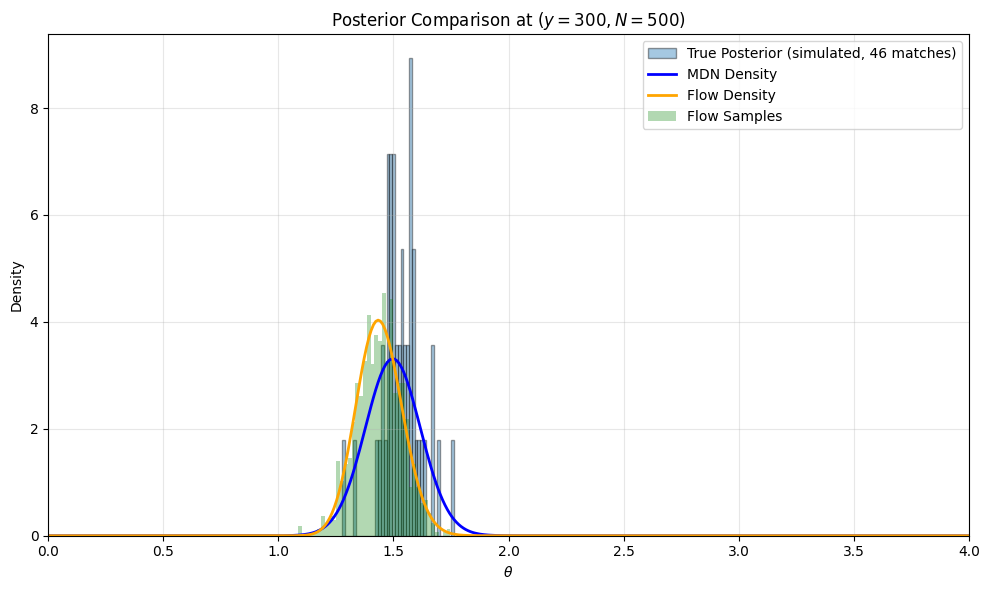

In [46]:
def compare_mdn_and_flow(mdn_model, flow_model, y_obs, N_obs, N_max, y_max, x_max, pair_dict, simulate_ground_truth=True, M=100000):
    y_norm, N_norm = y_obs / y_max, N_obs / N_max
    cond_tensor = torch.tensor([[N_norm, y_norm]], dtype=torch.float32)
    flow_cond = torch.tensor([[y_norm, N_norm]], dtype=torch.float32)

    theta_sampled_flow = flow_model.sample(flow_cond, n_samples=1000).detach().numpy().flatten() * x_max

    theta_grid = torch.linspace(1e-4, 1 - 1e-4, 500).unsqueeze(1)
    cond_grid = flow_cond.expand(theta_grid.shape[0], 2)
    with torch.no_grad():
        log_prob = flow_model(theta_grid, cond_grid)
        flow_density = (torch.exp(log_prob) / x_max).numpy().flatten()
    theta_grid_real = (theta_grid * x_max).numpy().flatten()

    with torch.no_grad():
        pi, mu, log_var = mdn_model(cond_tensor)
    pi = pi.numpy().flatten()
    mu = mu.numpy().flatten()
    sigma = np.sqrt(np.exp(log_var.numpy().flatten()))
    mdn_density = sum(pi[k] * norm.pdf(theta_grid_real, mu[k], sigma[k]) for k in range(len(pi)))

    key = (y_obs, N_obs)
    if key in pair_dict:
        true_theta_vals = np.array(pair_dict[key])
        label_gt = "True Posterior (from training)"
    elif simulate_ground_truth:
        theta_vals, y_vals = [], []
        for _ in range(M):
            theta = np.random.exponential(scale=1.0)
            y = sir_sim(N_obs, lam=theta)
            theta_vals.append(theta)
            y_vals.append(y)
        true_theta_vals = np.array([t for t, y in zip(theta_vals, y_vals) if y == y_obs])
        label_gt = f"True Posterior (simulated, {len(true_theta_vals)} matches)"
    else:
        true_theta_vals = None
        label_gt = None

    plt.figure(figsize=(10, 6))
    if true_theta_vals is not None and len(true_theta_vals) > 0:
        plt.hist(true_theta_vals, bins=40, density=True, alpha=0.4, label=label_gt, edgecolor='black')
    plt.plot(theta_grid_real, mdn_density, lw=2, label="MDN Density", color="blue")
    plt.plot(theta_grid_real, flow_density, lw=2, label="Flow Density", color="orange")
    plt.hist(theta_sampled_flow, bins=40, density=True, alpha=0.3, label="Flow Samples", color="green")

    plt.xlabel(r"$\theta$")
    plt.xlim(0, 4)
    plt.ylabel("Density")
    plt.title(rf"Posterior Comparison at $(y={y_obs}, N={N_obs})$")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


compare_mdn_and_flow(
    mdn_model=model,
    flow_model=flow,
    y_obs=300,
    N_obs=500,
    N_max=N_max,
    y_max=y_max,
    x_max=x_max,
    pair_dict=pair_dict,
    simulate_ground_truth=True
)


### Interpretation of the result

In this setting, we observe for multiple different pairs of y and N, so for N seen in the training dataset, like N = 100, 200 ,300, both models perform well. 

And for N unseen, we generate the data again and then compare. For now, the MDN is performing better than normalising flow for same architecture.

**Conclusion:** Both MDN and Flow demonstrate reasonable generalization to unseen \( N \), with MDN producing slightly smoother densities. This supports the potential of neural posterior approximators in amortized likelihood-free inference.

